# ANALYSE

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway

In [31]:
df = pd.read_csv("../data/CustomersNettoyé.csv")

## Test de Chi2 et Matrice de corrélation


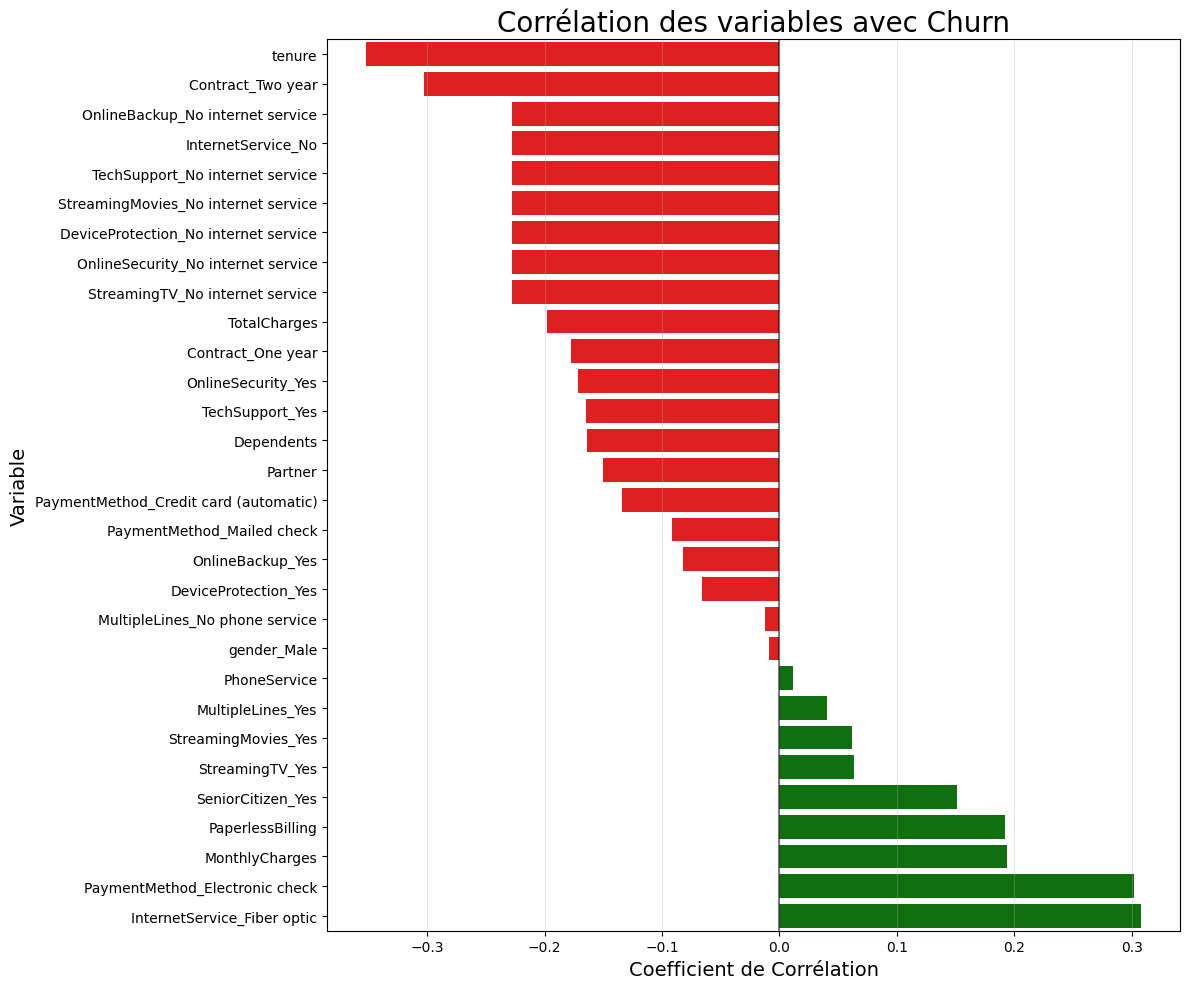

In [32]:
features_to_drop = [
    # Features avec très faible corrélation avec Churn
    'gender_Male',                   
    'PhoneService',                   
    'MultipleLines_No phone service', 
    
    # Variables catégorielles avec faible association
    'MultipleLines_Yes',              # V_Cramer = 0.039, très faible
    'StreamingMovies_Yes',            # V_Cramer = 0.061, faible
    'StreamingTV_Yes',                # V_Cramer = 0.062, faible
    'DeviceProtection_Yes',           # V_Cramer = 0.065, faible
    'OnlineBackup_Yes',               # V_Cramer = 0.081, faible
    'PaymentMethod_Mailed check', 
     
    # Charges totales (redondant avec MonthlyCharges)
    'TotalCharges',                   
    
    # Variables "No internet service" redondantes (garder seulement une)
    'OnlineBackup_No internet service', 
    'DeviceProtection_No internet service',
    'TechSupport_No internet service',
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
]



In [33]:
df = df.drop(columns=features_to_drop)

In [34]:
df.head()

,customerID,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,Churn,SeniorCitizen_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
0,7590-VHVEG,1,0,1,1,29.85,0,False,False,False,False,False,False,False,False,False,True
1,5575-GNVDE,0,0,34,0,56.95,0,False,False,False,False,True,False,True,False,False,False
2,3668-QPYBK,0,0,2,1,53.85,1,False,False,False,False,True,False,False,False,False,False
3,7795-CFOCW,0,0,45,0,42.30,0,False,False,False,False,True,True,True,False,False,False
4,9237-HQITU,0,0,2,1,70.70,1,False,True,False,False,False,False,False,False,False,True


In [35]:
df.dtypes

customerID                                object
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PaperlessBilling                           int64
MonthlyCharges                           float64
Churn                                      int64
SeniorCitizen_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
TechSupport_Yes                             bool
Contract_One year                           bool
Contract_Two year                           bool
PaymentMethod_Credit card (automatic)       bool
PaymentMethod_Electronic check              bool
dtype: object

In [36]:
df.to_csv("../data/CustomersFinal.csv", index=False)